## Install Libraries

In [1]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install unsloth
# Get latest Unsloth
!pip install --upgrade --no-deps "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
# %%

In [2]:
!pip install -q -U datasets

In [3]:
!pip install textattack


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 61.5 MB/s eta 0:00:00ta 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 50.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 445.7/445.7 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 769.7/769.7 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

## Text Augmentation for Balancing Fake Review Dataset

- This code loads a labeled dataset of real and fake reviews, and balances the class distribution using **WordNet-based synonym augmentation**.
- It uses the `TextAttack` library to synthetically generate more "fake" reviews by paraphrasing existing ones.
- The final balanced dataset is a combination of original real reviews and augmented fake reviews, ready for training classification models.


In [4]:
import pandas as pd
import random
import nltk
from textattack.augmentation import WordNetAugmenter

# Download the necessary nltk resources for WordNet
nltk.download('wordnet')
nltk.download('omw-1.4')

# Unzip the wordnet.zip file without interactive prompts
!unzip -o /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
!unzip -o /usr/share/nltk_data/corpora/omw.zip -d /usr/share/nltk_data/corpora/


textattack: Updating TextAttack package dependencies.
textattack: Downloading NLTK required packages.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw to /usr/share/nltk_data...
[nltk_data]   Package omw is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2025-04-12 16:59:16.879187: E external/local_xla/xla/stream_executor/cuda/cuda_

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [5]:

# Load the dataset from a CSV file
df = pd.read_csv('/kaggle/input/final-dataset-for-fake-review-detection/New_FAKE_final_Processed_labeled_reviews.csv')

# Replace label 1.0 with "real" and 0.0 with "fake"
df['label'] = df['label'].replace({1: 'real', 0: 'fake'})

# Remove all columns except 'reviewContent' and 'label'
df = df[['reviewContent', 'label']]

# Display initial data and label counts
print("Updated Dataset:")
print(df.head())  # Display the first few rows to verify

print("\nLabel Counts:")
print(df['label'].value_counts())  # Show the count of 'real' and 'fake' labels

# Initialize TextAttack augmenter
aug = WordNetAugmenter()

# Augment fake reviews to balance the dataset
augmented_reviews = []
num_fake_reviews_needed = len(df[df['label'] == 'real'])

# Extract fake reviews
fake_reviews = df[df['label'] == 'fake']['reviewContent'].tolist()

# Augment the fake reviews until the dataset is balanced
while len(augmented_reviews) < num_fake_reviews_needed:
    fake_review = random.choice(fake_reviews)  # Choose a random fake review
    augmented_review = aug.augment(fake_review)  # Generate augmented review using TextAttack
    augmented_reviews.extend(augmented_review)  # Add the augmented reviews to the list

# Create a DataFrame for the augmented fake reviews
augmented_df = pd.DataFrame(augmented_reviews, columns=['reviewContent'])
augmented_df['label'] = 'fake'

# Combine augmented data with the original real data
balanced_df = pd.concat([df[df['label'] == 'real'], augmented_df], ignore_index=True)

# Check the balance of the dataset after augmentation
print("\nBalanced Label Counts:")
print(balanced_df['label'].value_counts())

# Display the first few rows of the balanced dataset
print("\nBalanced Dataset:")
print(balanced_df.head())


Updated Dataset:
                                       reviewContent label
0                  Small, it won't work for the car.  real
1  Very satisfied with the product, it is really ...  real
2             Very satisfied with this little vacuum  real
3               Just a bomb! Works like a hurricane!  real
4                            Strong and good suction  fake

Label Counts:
label
real    12916
fake     4691
Name: count, dtype: int64


[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



Balanced Label Counts:
label
real    12916
fake    12916
Name: count, dtype: int64

Balanced Dataset:
                                       reviewContent label
0                  Small, it won't work for the car.  real
1  Very satisfied with the product, it is really ...  real
2             Very satisfied with this little vacuum  real
3               Just a bomb! Works like a hurricane!  real
4          This thing is a monster. Worth every coin  real


## Text Preprocessing with Lemmatization

- This code preprocesses the balanced dataset by **lowercasing, removing punctuation, tokenizing, and lemmatizing** each review.
- It uses **NLTK's WordNet lemmatizer** to reduce words to their base form for better generalization.
- The cleaned dataset is saved as `fake balanced dataset.csv`, ready for model training or embedding.


In [ ]:
import pandas as pd
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('wordnet')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Use your balanced dataset
df = balanced_df.copy()

# Define preprocessing function without stopwords
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = ' '.join(text.split())  # Remove extra whitespace
    tokens = word_tokenize(text)  # Tokenize
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize
    return ' '.join(tokens)

# Apply preprocessing
df['reviewContent'] = df['reviewContent'].astype(str).apply(preprocess_text)

df.to_csv('fake balanced dataset.csv', index=False)
# Output
print("Processed DataFrame size (rows, columns):", df.shape)
print(df.head())


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Processed DataFrame size (rows, columns): (25832, 2)
                                       reviewContent label
0                     small it wont work for the car  real
1  very satisfied with the product it is really q...  real
2             very satisfied with this little vacuum  real
3                  just a bomb work like a hurricane  real
4           this thing is a monster worth every coin  real


## Get Started with the Balanced Dataset

In [3]:
import pandas as pd
# Load the dataset from a CSV file
df = pd.read_csv('/kaggle/input/balanced-fake-reviews/fake balanced dataset.csv')

# Remove all columns except 'reviewContent' and 'label'
df = df[['reviewContent', 'label']]

df.head(10)

,reviewContent,label
0,small it wont work for the car,real
1,very satisfied with the product it is really q...,real
2,very satisfied with this little vacuum,real
3,just a bomb work like a hurricane,real
4,this thing is a monster worth every coin,real
5,thank you i will be using and remaining,real
6,very good car indoor cleaning and keyboard win...,real
7,thank you for shipping everything a described,real
8,very good product who aspiers well i recommend,real
9,good put on charge,real


## Train-Test-Eval Split with Balanced Sampling

- Splits the dataset **label-wise** into a fixed number of training (7,000) and test (5,000) samples for each class (`real`, `fake`).
- Additionally selects a small **evaluation set (50 per class)** from the unused data, ensuring balanced label distribution for quick model checks.


In [4]:
from sklearn.model_selection import train_test_split
X_train = list()
X_test = list()
for label in ["real", "fake"]:
    train, test  = train_test_split(df[df.label==label],
                                    train_size=7000,#12000x60%
                                    test_size=5000,#12000x40%
                                    random_state=42)
    X_train.append(train)
    X_test.append(test)

X_train = pd.concat(X_train).sample(frac=1, random_state=10)
X_test = pd.concat(X_test)

eval_idx = [idx for idx in df.index if idx not in list(train.index) + list(test.index)]
X_eval = df[df.index.isin(eval_idx)]
X_eval = (X_eval
          .groupby('label', group_keys=False)
          .apply(lambda x: x.sample(n=50, random_state=10, replace=True)))
X_train = X_train.reset_index(drop=True)

/tmp/ipykernel_31/2371259830.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=50, random_state=10, replace=True)))


## Prompt Generation for Instruction-Tuned LLM Training

- Generates **instruction-style prompts** for `real` vs `fake` review classification using training, test, and evaluation splits.
- Uses a structured prompt format with input enclosed in brackets and a direct label for training; the label is left blank in test prompts.
- Converts the processed data into Hugging Face `Dataset` objects, preparing it for fine-tuning or evaluation with LLMs.


In [5]:
# Function to generate the prompt for training data
def generate_prompt(data_point):
    return f"""
            Determine if the review enclosed in square brackets is real or fake based on its content.
            Return the answer as either "real" or "fake".

            [{data_point["reviewContent"]}] = {data_point["label"]}
            """.strip()



In [6]:
from datasets import Dataset
# Function to generate the prompt for testing data
def generate_test_prompt(data_point):
    return f"""
            Determine if the review enclosed in square brackets is real or fake based on its content.
            Return the answer as either "real" or "fake".

            [{data_point["reviewContent"]}] =
            """.strip()

# Assuming X_train, X_eval, and X_test are pandas DataFrames containing the 'reviewContent' and 'label' columns
# Apply the prompt generation function to the training and evaluation data
X_train = pd.DataFrame(X_train.apply(generate_prompt, axis=1), columns=["reviewContent"])
X_eval = pd.DataFrame(X_eval.apply(generate_prompt, axis=1), columns=["reviewContent"])

# The labels for the true values (test set) would be used for evaluation
y_true = X_test['label']

# Generate test prompts for the test set
X_test = pd.DataFrame(X_test.apply(generate_test_prompt, axis=1), columns=["reviewContent"])

# Convert to Hugging Face datasets
train_data = Dataset.from_pandas(X_train)
eval_data = Dataset.from_pandas(X_eval)


## Evaluation Function for Binary Classification

- Evaluates predicted labels (`real` vs `fake`) using **accuracy, classification report**, and **confusion matrix**.
- Includes per-class accuracy breakdown using a label-to-int mapping (`real` = 1, `fake` = 0).
- Helps diagnose model performance across individual labels and understand misclassification patterns.


In [7]:
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix)
import numpy as np
def evaluate(y_true, y_pred):
    labels = ['real', 'fake']
    mapping = {'real': 1, 'fake': 0}
    def map_func(x):
        return mapping.get(x, 1)

    y_true = np.vectorize(map_func)(y_true)
    y_pred = np.vectorize(map_func)(y_pred)

    # Calculate accuracy
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    print(f'Accuracy: {accuracy:.3f}')

    # Generate accuracy report
    unique_labels = set(y_true)  # Get unique labels

    for label in unique_labels:
        label_indices = [i for i in range(len(y_true))
                         if y_true[i] == label]
        label_y_true = [y_true[i] for i in label_indices]
        label_y_pred = [y_pred[i] for i in label_indices]
        accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label {label}: {accuracy:.3f}')

    # Generate classification report
    class_report = classification_report(y_true=y_true, y_pred=y_pred)
    print('\nClassification Report:')
    print(class_report)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=[0, 1])
    print('\nConfusion Matrix:')
    print(conf_matrix)

## Loading a 4-bit Quantized Mistral Model with Unsloth

- Loads a fine-tuned **Mistral-7B model** using Unsloth with 4-bit quantization for efficient memory usage.
- Uses `bitsandbytes` to identify all linear modules within the model that can be targeted for **LoRA fine-tuning**.
- Prints the list of module names suitable for LoRA adaptation, helping customize which layers to train.


In [8]:
import unsloth
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/mistral-7b-instruct-v0.2-bnb-4bit",
    "unsloth/llama-2-7b-bnb-4bit",
    "unsloth/gemma-7b-bnb-4bit",
    "unsloth/gemma-7b-it-bnb-4bit", # Instruct version of Gemma 7b
    "unsloth/gemma-2b-bnb-4bit",
    "unsloth/gemma-2b-it-bnb-4bit", # Instruct version of Gemma 2b
] # More models at https://huggingface.co/unsloth
#https://huggingface.co/AbuSalehMd/FakeReviewDetection_Mistral_7B_FineTuned
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "AbuSalehMd/FakeReviewDetection_Mistral_7B_FineTuned", # Choose ANY! eg teknium/OpenHermes-2.5-Mistral-7B
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-04-12 19:12:29.350057: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744485149.541853      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744485149.596615      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Unsloth: Failed to patch Gemma3ForConditionalGeneration.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.3.19: Fast Mistral patching. Transformers: 4.51.1.
   \\   /|    Tesla P100-PCIE-16GB. Num GPUs = 1. Max memory: 15.888 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 6.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/4.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/155 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/671M [00:00<?, ?B/s]

Unsloth 2025.3.19 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [14]:
import bitsandbytes as bnb
def find_all_linear_names(model):
  cls = bnb.nn.Linear4bit #if args.bits == 4 else (bnb.nn.Linear8bitLt if args.bits == 8 else torch.nn.Linear)
  lora_module_names = set()
  for name, module in model.named_modules():
    if isinstance(module, cls):
      names = name.split('.')
      lora_module_names.add(names[0] if len(names) == 1 else names[-1])
    if 'lm_head' in lora_module_names: # needed for 16-bit
      lora_module_names.remove('lm_head')
  return list(lora_module_names)
modules = find_all_linear_names(model)

In [17]:
modules = find_all_linear_names(model)
print(modules)

['v_proj', 'k_proj', 'up_proj', 'gate_proj', 'q_proj', 'down_proj', 'o_proj']


## Prediction Loop for LLM Classification using Prompts

- Iterates through a prompt-based test set and generates predictions using the loaded LLM (e.g., Mistral-7B).
- Uses `tqdm` to display progress and decodes the model's output to extract `"real"` or `"fake"` labels.
- Returns a list of predicted labels, enabling direct evaluation with `y_true`.


In [9]:
from tqdm import tqdm
def predict(X_test, model, tokenizer):
    y_pred = []
    for i in tqdm(range(len(X_test))):
        prompt = X_test.iloc[i]["reviewContent"]
        input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
        outputs= model.generate(**input_ids,pad_token_id=tokenizer.eos_token_id, max_new_tokens=1,temperature=0.0)
        result = tokenizer.decode(outputs[0])
        answer = result.split("=")[-1].lower()
        if "real" in answer:
            y_pred.append("real")
        elif "fake" in answer:
            y_pred.append("fake")
        else:
            y_pred.append("none")
    return y_pred

## Pre Model Evaluation on Test Set

- Achieved **46.4% accuracy** on the 10,000-example test set for fake review detection.
- Label-wise performance:
  - Fake (0): 1.60% accuracy
  - Real (1): 0.767% accuracy
- Classification metrics low precision and recall across both classes.

In [21]:
y_pred = predict(X_test, model, tokenizer)

100%|██████████| 10000/10000 [49:54<00:00,  3.34it/s] 


In [23]:
evaluate(y_true, y_pred)

Accuracy: 0.464
Accuracy for label 0: 0.160
Accuracy for label 1: 0.767

Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.16      0.23      5000
           1       0.48      0.77      0.59      5000

    accuracy                           0.46     10000
   macro avg       0.44      0.46      0.41     10000
weighted avg       0.44      0.46      0.41     10000


Confusion Matrix:
[[ 802 4198]
 [1164 3836]]


## Applying LoRA to Enable Efficient Fine-Tuning

- Adds **Low-Rank Adaptation (LoRA)** layers to the loaded LLM using `FastLanguageModel.get_peft_model()` for parameter-efficient fine-tuning.
- Targets only the specified linear modules with a rank `r=64`, alpha scaling, and no dropout for optimized performance.


In [24]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 64, 
    target_modules = modules,
    lora_alpha = 32,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    use_gradient_checkpointing = True,
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.3.19 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


## Training Mistral-7B with LoRA Using SFTTrainer

- Fine-tuned Mistral-7B using LoRA with `trl.SFTTrainer` on 14,000 prompt-based fake review examples.
- Training performed on 1 GPU with 2 trainable LoRA layers (`2.40%` of total parameters).
- Gradient accumulation and small batch sizes enabled efficient resource usage on limited hardware.
- Final training loss achieved: `0.6578` after 3 epochs and 5,250 steps.


In [25]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset=train_data,
    eval_dataset=eval_data,
    dataset_text_field = "reviewContent",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        num_train_epochs = 3,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 100,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",
    ),
)

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Unsloth: Tokenizing ["reviewContent"] (num_proc=2):   0%|          | 0/14000 [00:00<?, ? examples/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Unsloth: Tokenizing ["reviewContent"] (num_proc=2):   0%|          | 0/100 [00:00<?, ? examples/s]

In [26]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla P100-PCIE-16GB. Max memory = 15.888 GB.
7.246 GB of memory reserved.


In [27]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 14,000 | Num Epochs = 3 | Total steps = 5,250
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 167,772,160/7,000,000,000 (2.40% trained)


Step,Training Loss
100,1.145100
200,1.039900
300,0.990100
400,0.983100
500,0.988900
600,0.913500
700,0.948000
800,0.950100
900,0.973100
1000,0.963200


Unsloth: Will smartly offload gradients to save VRAM!


In [28]:
trainer_stats

TrainOutput(global_step=5250, training_loss=0.6578686774117606, metrics={'train_runtime': 34226.1072, 'train_samples_per_second': 1.227, 'train_steps_per_second': 0.153, 'total_flos': 1.2305796806610125e+17, 'train_loss': 0.6578686774117606})

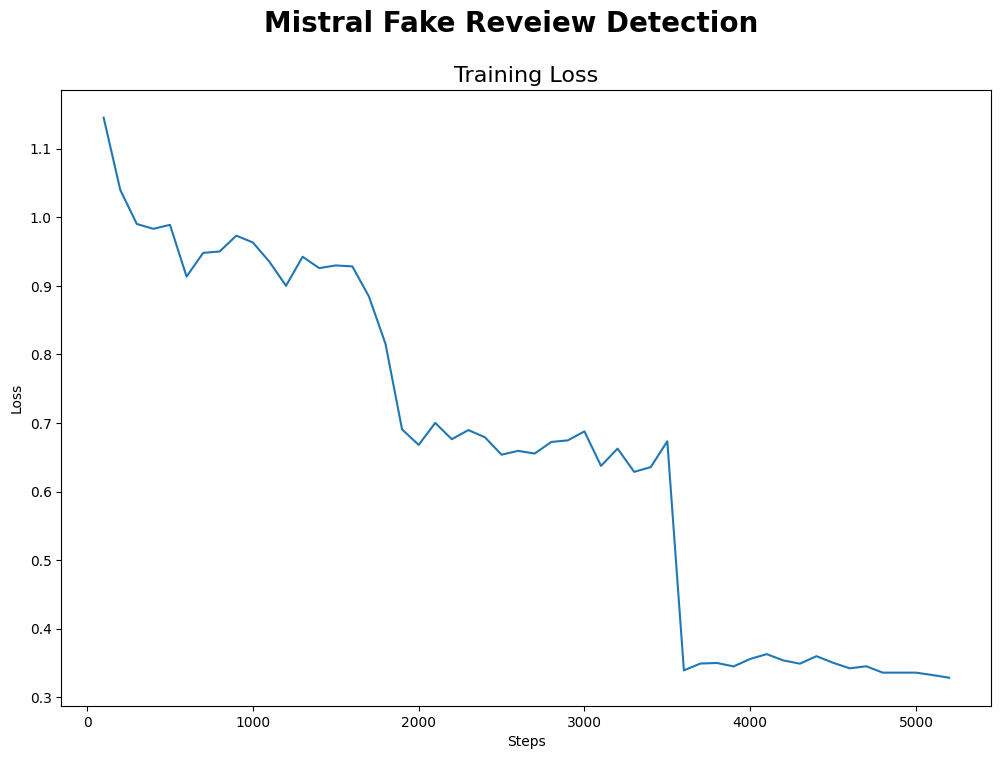

In [ ]:
import matplotlib.pyplot as plt

# Extract the training losses from the log history
losses = [log["loss"] for log in trainer.state.log_history if "loss" in log]
# Extract the training steps from the log history
steps = [log["step"] for log in trainer.state.log_history if "loss" in log]

# Create the figure with larger size
plt.figure(figsize=(12, 8))  # Adjust the width and height (in inches)

# Plotting the loss curve
plt.plot(steps, losses)

# Adding a heading for the figure
plt.suptitle("Mistral Fake Reveiew Detection", fontsize=20, fontweight='bold')

# Adding the title, axis labels, and displaying the plot
plt.title("Training Loss", fontsize=16)
plt.xlabel("Steps", fontsize=10)
plt.ylabel("Loss", fontsize=10)

# Display the plot
plt.show()

In [30]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

34226.1072 seconds used for training.
570.44 minutes used for training.
Peak reserved memory = 7.918 GB.
Peak reserved memory for training = 0.672 GB.
Peak reserved memory % of max memory = 49.836 %.
Peak reserved memory for training % of max memory = 4.23 %.


## Model Evaluation on Test Set

- Achieved **94.5% accuracy** on the 10,000-example test set for fake review detection.
- Label-wise performance:
  - Fake (0): 93.8% accuracy
  - Real (1): 95.3% accuracy
- Classification metrics show strong precision and recall across both classes.
- Confusion matrix indicates balanced prediction performance with minimal misclassification.


In [10]:
y_pred = predict(X_test, model, tokenizer)
evaluate(y_true, y_pred)

100%|██████████| 10000/10000 [58:51<00:00,  2.83it/s] 

Accuracy: 0.945
Accuracy for label 0: 0.938
Accuracy for label 1: 0.953

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      5000
           1       0.94      0.95      0.95      5000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000


Confusion Matrix:
[[4688  312]
 [ 236 4764]]


## Saving and Uploading the Fine-Tuned Model

- Saved the fine-tuned Mistral-7B model locally using `model.save_pretrained()`.
- Uploaded the model to Hugging Face Hub under the name `AbuSalehMd/FakeReviewDetection_Mistral_7B_FineTuned` using `push_to_hub()`.


In [ ]:
model.save_pretrained("Fake Review Detection Mistral 7B Fine Tuned")


In [ ]:
model.push_to_hub("AbuSalehMd/FakeReviewDetection_Mistral_7B_FineTuned", token = "hf_XXXX")

README.md:   0%|          | 0.00/581 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/671M [00:00<?, ?B/s]

Saved model to https://huggingface.co/AbuSalehMd/FakeReviewDetection_Mistral_7B_FineTuned
